In [1]:
# default_exp standard_themes/metadata

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Tritonlytics MultiTask Classification - Standard Themes Metadata

> Multi-modal models for predicting IsExample and Theme sentiment

In [3]:
#export
import datetime
import sklearn.metrics as skm
from tritonlytics_ai.utils import *

from fastai import __version__ as fa2_version
from fastai.text.all import *
from blurr.modeling.all import MultiTargetLoss

import spacy
spacy_en = spacy.load('en_core_web_sm')
spacy_es = spacy.load('es_core_news_sm')

In [4]:
#hide
import pdb, gc

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [5]:
#hide
print(f'fastai version: {fa2_version}')

fastai version: 2.0.14


In [6]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

Basic Configuration

In [7]:
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb')); len(vocab)

32408

In [8]:
bsz = 80
bptt= 72
wd = 1e-7

In [9]:
chunksize = 24000

include_fld_tok = True
include_bos_tok = True
include_eos_tok = False

In [10]:
# define what text columns to use (can be multiple)
corpus_cols = ['theme', 'answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '_multitask' #'_cleaned'

Prepare the data source

In [11]:
train_df = pd.read_csv(STANDARD_THEME_META_PATH/'train.csv')
valid_df = pd.read_csv(STANDARD_THEME_META_PATH/'test.csv')

In [12]:
train_df.is_example.dtype

dtype('int64')

Remove any rows whre the "corpus_cols" are nan

In [13]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [14]:
# list(set(train_df.theme.unique()))

In [15]:
# vocab.itos += [ item.lower() for item in list(set(train_df.theme.unique())) ]
# vocab.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(vocab.itos)})

In [16]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df])

In [17]:
# prepend custom tokenization rules to defaults
custom_lowercase = partial(lowercase, add_bos=include_bos_tok, add_eos=include_eos_tok)

custom_tok_rules = defaults.text_proc_rules[:-1] + [custom_lowercase, 
                                                    make_replacements, 
                                                    fix_ampm, 
                                                    fix_sentence_ends, 
                                                    fix_hyphenated_words]

Using the mid-level `DataBlocks` API

In [18]:
%%time

blocks = (
    TextBlock.from_df(corpus_cols, vocab=vocab, seq_len=bptt, rules=custom_tok_rules, mark_fields=include_fld_tok),
    RegressionBlock(),
    CategoryBlock()
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'),
                   get_y=[ColReader('avg_sentiment'), ColReader('is_example')],
                   splitter=ColSplitter(col='is_valid'), 
                   n_inp=1)

CPU times: user 132 ms, sys: 3.91 ms, total: 136 ms
Wall time: 136 ms


In [19]:
# dblock.summary(df)

In [20]:
%%time
dls = dblock.dataloaders(df, bs=bsz, seq_len=bptt)

CPU times: user 13.6 s, sys: 1.4 s, total: 15 s
Wall time: 15.9 s


In [21]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (2 items)


In [22]:
print(dls.train_ds[21])

(TensorText([   2,    4,  371,    8,  458,   68,    8, 5843,   68,    8,  475,    4,
         290,  109,   17,   10,   27,   38,  323, 1260,   49,  322,  636,   11,
         675, 4474,   21,   26,   32,   57,  684,   11,   30,  122,    9]), tensor(3.), TensorCategory(0))


In [23]:
dls.show_batch(max_n=2)

,text,text_,category
0,"xxbos xxfld 1 xxmaj supervisor xxmaj effectiveness / xxmaj resolves xxmaj staff xxmaj issues xxfld 2 xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse",1.0,0
1,"xxbos xxfld 1 xxmaj evaluated xxmaj fairly xxfld 2 xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of",1.0,0


In [24]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[2].size(), batch[1].type(), batch[2].type(), bsz)

torch.Size([80, 482]) torch.cuda.LongTensor torch.Size([80]) torch.Size([80]) torch.cuda.FloatTensor torch.cuda.LongTensor 80


In [25]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

"xxbos xxfld 1 xxmaj supervisor xxmaj effectiveness / xxmaj resolves xxmaj staff xxmaj issues xxfld 2 xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj califor

Save the `Dataloaders` object for future use

In [26]:
# save dataloaders
torch.save(dls, STANDARD_THEME_META_PATH/f'data_standard_theme_meta.pkl')
# dls = torch.load(STANDARD_THEME_META_PATH/f'data_standard_theme_meta.pkl')

## Training

Configure a forward or backwards run

In [92]:
backwards = False
m_suf = '_multitask' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

dls = torch.load(STANDARD_THEME_META_PATH/f'data_standard_theme_meta.pkl')

def reverse_text(nums): return nums.flip(0)
if (backwards): 
    dls.tfms.append(Transform(reverse_text))
    dls.before_batch = partial(pad_input_chunk, pad_first=not backwards)

In [93]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {STANDARD_THEME_META_PATH/'models/'}  

Configure MM head

In [94]:
class MM(Module):
    def __init__(self, in_features=50): 
        super().__init__()
        self.pred_is_example = nn.Linear(in_features, 2, bias=False)
        self.pred_avg_sentiment = nn.Linear(in_features, 1, bias=False)
        self.pred_avg_sent_range = SigmoidRange(1., 5.1)
        
    def forward(self, x):
        is_example = self.pred_is_example(x)
        avg_sentiment = self.pred_avg_sent_range(self.pred_avg_sentiment(x))
        
        return avg_sentiment, is_example

In [95]:
is_example_weights = list(np.max(train_df.is_example.value_counts()) /train_df.is_example.value_counts())
print(is_example_weights)

[1.0, 115.48148148148148]


Configure learner

In [96]:
# define metrics
def sentiment_mse(preds, *targs):
    return mse(preds[0], targs[0])

def is_example_acc(preds, *targs):
    return accuracy(preds[1], targs[1])

In [97]:
# define callbacks
best_model_cb = SaveModelCallback(monitor='valid_loss', comp=np.less, fname=f'{m_pre}mm_bestmodel{m_suf}')

In [98]:
# define our custom multi-target loss
multi_targ_loss = MultiTargetLoss(loss_classes=[MSELossFlat, CrossEntropyLossFlat],
                                  loss_classes_kwargs=[{}, {'weight': FloatTensor(is_example_weights).to('cuda:1')}],
                                  weights=[1, 0.1], 
                                  reduction='mean')

In [99]:
learn_cbs = []
fit_cbs = [best_model_cb]

learn_metrics = [is_example_acc, sentiment_mse]

# build learner
learn = text_classifier_learner(dls, 
                                AWD_LSTM, 
                                pretrained=False,
                                alpha=2.0, beta=1.0,      # default - alpha=2.0, beta=1.0
                                moms=(0.8,0.7,0.8),       # default - (0.95, 0.85, 0.95)
                                wd=wd,                    # default - None
                                seq_len=bptt,             # default - 72
                                drop_mult=0.5,            # default - 0.5
                                lin_ftrs=[50],            # default - [50]
                                ps=[0.1],                 # default - [0.1]
                                metrics=learn_metrics, 
                                cbs=learn_cbs,
                                n_out=1,
                                path=STANDARD_THEME_META_PATH)

learn.loss_func = multi_targ_loss

In [100]:
# learn.summary()

In [101]:
learn = learn.load_encoder(f'{m_pre}lm_enc')

In [102]:
learn.model._modules['1']._modules['layers']._modules['1']

LinBnDrop(
  (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): Linear(in_features=50, out_features=1, bias=False)
)

In [103]:
learn.model._modules['1']._modules['layers']._modules['1']._modules['2'] = MM(50)

In [104]:
learn.model = learn.model.to('cuda:1')

In [105]:
learn.splitter = awd_lstm_clas_split
learn.opt = learn.create_opt()

In [106]:
learn.freeze()

In [107]:
learn.summary()

SequentialRNN (Input shape: ['80 x 482'])
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           80 x 50 x 400        0          False     
________________________________________________________________
RNNDropout           80 x 50 x 1152       0          False     
________________________________________________________________
RNNDropout           80 x 50 x 1152       0          False     
________________________________________________________________
BatchNorm1d          80 x 1200            2,400      True      
________________________________________________________________
Dropout              80 x 1200            0          False     
________________________________________________________________
Linear               80 x 50              60,000     True      
________________________________________________________________
ReLU                 80 x 50              0          False     
________________________________________________________

In [108]:
# learn.show_training_loop()

In [109]:
best_model_path = STANDARD_THEME_META_PATH/f'models/{m_pre}mm_bestmodel{m_suf}*'
if (best_model_path.exists()): best_model_path.unlink(missing_ok=False)

Train

In [110]:
lr= 5e-2

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=1.5848931980144698e-06)

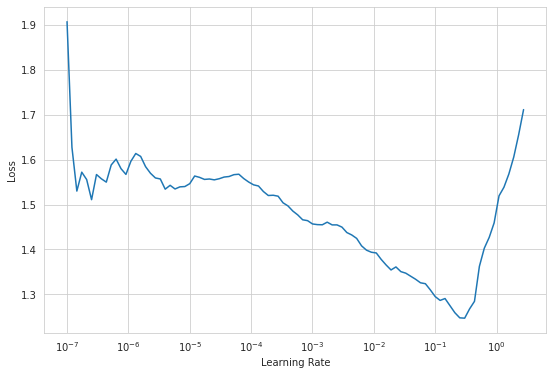

In [111]:
learn.lr_find()

In [112]:
learn.fit_one_cycle(1, lr_max=lr, cbs=fit_cbs)

epoch,train_loss,valid_loss,is_example_acc,sentiment_mse,time
0,0.733456,0.526497,0.908484,0.482469,00:12


Better model found at epoch 0 with valid_loss value: 0.5264973640441895.


In [113]:
learn.save(f'{m_pre}mm_last_ft{m_suf}')

Path('data/classification/standard_themes/meta/models/fwd_mm_last_ft_multitask.pth')

In [114]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, lr_max=slice(5e-2/(2.6**4), 5e-2), cbs=fit_cbs)

epoch,train_loss,valid_loss,is_example_acc,sentiment_mse,time
0,0.612754,0.494718,0.909438,0.444064,00:13


Better model found at epoch 0 with valid_loss value: 0.4947182834148407.


In [115]:
learn.save(f'{m_pre}mm_last2_ft{m_suf}')

Path('data/classification/standard_themes/meta/models/fwd_mm_last2_ft_multitask.pth')

In [116]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, lr_max=slice(1e-2/(2.6**4),5e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,is_example_acc,sentiment_mse,time
0,0.485630,0.441041,0.959962,0.393227,00:19


Better model found at epoch 0 with valid_loss value: 0.44104138016700745.


In [117]:
learn.save(f'{m_pre}mm_last3_ft{m_suf}')

Path('data/classification/standard_themes/meta/models/fwd_mm_last3_ft_multitask.pth')

In [118]:
learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(5e-3/(2.6**4),5e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,is_example_acc,sentiment_mse,time
0,0.430081,0.436342,0.929457,0.390007,00:25
1,0.406086,0.426981,0.897998,0.380801,00:25
2,0.385023,0.454818,0.872259,0.407560,00:25
3,0.318625,0.454470,0.965682,0.397874,00:25
4,0.294054,0.464966,0.976168,0.387045,00:25
5,0.258420,0.462405,0.968541,0.397607,00:25
6,0.232994,0.481579,0.972355,0.397500,00:25
7,0.213427,0.497897,0.975214,0.407183,00:25
8,0.206671,0.511222,0.980934,0.406714,00:25
9,0.200293,0.503890,0.974261,0.406936,00:26


Better model found at epoch 0 with valid_loss value: 0.4363422691822052.
Better model found at epoch 1 with valid_loss value: 0.4269811809062958.


In [119]:
learn.save(f'{m_pre}mm{m_suf}')

Path('data/classification/standard_themes/meta/models/fwd_mm_multitask.pth')

Export model for inference

In [120]:
learn.export(fname=f'{m_pre}export_mm{m_suf}.pkl')

Look at results

In [121]:
learn = learn.load(f'{m_pre}mm_bestmodel{m_suf}')

In [122]:
learn.validate() # ... returns [loss, metrics]

(#3) [0.4269811809062958,0.8979980945587158,0.38080084323883057]

In [123]:
learn.show_results(max_n=4, trunc_at=60)

,text,text_,category,text__,category_
0,"xxbos xxfld 1 xxmaj advancement and xxmaj training xxmaj opportunities xxfld 2 xxmaj insights as alumna / former student of xxup ucsd , working on main campus 3.5 + years , mexican - american female & varied experience from start - up to non - profit to corporate : \ r \n 1 . xxmaj dept / culture : all",3.0,0,"(2.162134885787964,)",0
1,"xxbos xxfld 1 xxmaj satisfied with xxmaj diversity xxmaj xxunk xxfld 2 xxmaj my work environment at xxup s. xxup i. xxup o. xxmaj directors office , has been very unsatisfactory . xxmaj when my former work director xxmaj gary xxmaj xxunk retired , xxmaj dennis xxmaj brand took over as my work director . xxmaj he did not seem",1.0,0,"(2.069725513458252,)",1
2,"xxbos xxfld 1 xxmaj internal xxmaj processes xxmaj effective xxfld 2 xxmaj if you are under a xxmaj union xxmaj contract , i was told that my annual review does n't matter . i will receive my 3 % raise each year no matter what . xxmaj where is the incentive to go above and beyond ? xxmaj the departments",2.0,0,"(2.7194347381591797,)",0
3,"xxbos xxfld 1 xxmaj have xxmaj voice within my xxmaj institution / xxmaj valued xxmaj member of my xxmaj institution xxfld 2 i am satisfied with my department but very dissatisfied with xxup anr at the state / headquarters level . xxmaj in my department , i have a voice , can influence small decisions and am recognized for my",2.0,0,"(2.025029182434082,)",0


Use it for inference

In [124]:
inf_learn = load_learner(STANDARD_THEME_META_PATH/f'{m_pre}export_mm{m_suf}.pkl')

In [125]:
inf_learn.predict('I feel very uncomfortable talking to my supervisor even though she loves dogs. Help!!!', 
                  with_input=True)

('xxbos i feel very uncomfortable talking to my supervisor even though she loves dogs . xxmaj help xxrep 3 !',
 ((2.1534781455993652), '1'),
 tensor([[2.1535]]),
 tensor([[2.1535]]))

Review final validation loss for best model

In [126]:
print(STANDARD_THEME_META_LABELS)

['avg_sentiment', 'is_example']


In [127]:
learn = learn.load(f'{m_pre}mm_bestmodel{m_suf}')

In [128]:
learn.validate()

(#3) [0.4269811809062958,0.8979980945587158,0.38080084323883057]

In [129]:
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.49097761511802673


In [130]:
for prob_sent, prob_example, targ_sent, targ_example in zip(*probs,*targs):
    print(prob_sent, targ_sent, torch.argmax(prob_example, dim=-1), targ_example)

tensor([1.7855]) tensor(2.) tensor(0) tensor(0)
tensor([1.8570]) tensor(2.) tensor(0) tensor(0)
tensor([4.4427]) tensor(4.) tensor(0) tensor(0)
tensor([2.0007]) tensor(2.) tensor(0) tensor(0)
tensor([4.1403]) tensor(4.) tensor(0) tensor(0)
tensor([1.8239]) tensor(2.) tensor(0) tensor(0)
tensor([4.4053]) tensor(5.) tensor(0) tensor(0)
tensor([2.8118]) tensor(2.) tensor(1) tensor(0)
tensor([2.4978]) tensor(3.) tensor(0) tensor(0)
tensor([2.4700]) tensor(4.) tensor(0) tensor(0)
tensor([1.9128]) tensor(2.) tensor(0) tensor(0)
tensor([4.3134]) tensor(5.) tensor(0) tensor(0)
tensor([2.1398]) tensor(2.) tensor(0) tensor(0)
tensor([2.1975]) tensor(2.) tensor(0) tensor(0)
tensor([1.7298]) tensor(1.) tensor(1) tensor(0)
tensor([2.7021]) tensor(1.5000) tensor(0) tensor(0)
tensor([2.5804]) tensor(5.) tensor(1) tensor(0)
tensor([2.5860]) tensor(3.) tensor(0) tensor(0)
tensor([1.8714]) tensor(2.) tensor(0) tensor(0)
tensor([2.7017]) tensor(3.) tensor(0) tensor(0)
tensor([1.7657]) tensor(2.) tensor(0

tensor([1.9153]) tensor(2.) tensor(0) tensor(0)
tensor([1.9520]) tensor(2.) tensor(0) tensor(0)
tensor([2.2392]) tensor(4.) tensor(0) tensor(0)
tensor([2.4559]) tensor(3.) tensor(0) tensor(0)
tensor([1.9829]) tensor(2.) tensor(0) tensor(0)
tensor([1.7738]) tensor(2.) tensor(1) tensor(0)
tensor([2.1746]) tensor(2.) tensor(0) tensor(0)
tensor([1.9718]) tensor(2.) tensor(0) tensor(0)
tensor([1.8980]) tensor(2.) tensor(0) tensor(0)
tensor([2.2898]) tensor(2.) tensor(0) tensor(0)
tensor([2.0442]) tensor(2.) tensor(0) tensor(0)
tensor([1.8237]) tensor(2.) tensor(1) tensor(0)
tensor([1.6772]) tensor(1.) tensor(0) tensor(0)
tensor([2.0750]) tensor(3.) tensor(0) tensor(0)
tensor([1.4497]) tensor(1.5000) tensor(1) tensor(0)
tensor([3.1290]) tensor(3.) tensor(0) tensor(0)
tensor([2.3939]) tensor(2.) tensor(0) tensor(0)
tensor([3.9126]) tensor(5.) tensor(0) tensor(0)
tensor([1.7650]) tensor(2.) tensor(1) tensor(0)
tensor([2.0897]) tensor(1.) tensor(0) tensor(0)
tensor([1.8333]) tensor(2.) tensor(0

tensor([2.1173]) tensor(2.5000) tensor(0) tensor(0)
tensor([2.3668]) tensor(1.5000) tensor(0) tensor(0)
tensor([1.9547]) tensor(2.) tensor(0) tensor(0)
tensor([2.1861]) tensor(3.) tensor(0) tensor(0)
tensor([2.0737]) tensor(2.5000) tensor(0) tensor(0)
tensor([4.6645]) tensor(5.) tensor(0) tensor(0)
tensor([2.9889]) tensor(3.) tensor(0) tensor(0)
tensor([2.0715]) tensor(2.) tensor(0) tensor(0)
tensor([2.6372]) tensor(2.) tensor(0) tensor(0)
tensor([2.2347]) tensor(2.) tensor(0) tensor(0)
tensor([2.3114]) tensor(1.5000) tensor(0) tensor(0)
tensor([2.3449]) tensor(2.) tensor(0) tensor(0)
tensor([4.5768]) tensor(5.) tensor(0) tensor(0)
tensor([2.2603]) tensor(2.) tensor(0) tensor(0)
tensor([1.9922]) tensor(1.) tensor(0) tensor(0)
tensor([2.2241]) tensor(2.) tensor(0) tensor(0)
tensor([2.2776]) tensor(3.) tensor(0) tensor(0)
tensor([2.7774]) tensor(4.) tensor(0) tensor(0)
tensor([1.9501]) tensor(2.) tensor(0) tensor(0)
tensor([2.0704]) tensor(2.5000) tensor(0) tensor(0)
tensor([1.9076]) ten

tensor([4.5139]) tensor(4.5000) tensor(0) tensor(0)
tensor([2.5406]) tensor(3.) tensor(0) tensor(0)
tensor([2.0587]) tensor(2.) tensor(0) tensor(0)
tensor([4.7169]) tensor(4.) tensor(0) tensor(0)
tensor([2.3372]) tensor(3.) tensor(0) tensor(0)
tensor([2.7880]) tensor(3.) tensor(0) tensor(0)
tensor([1.9271]) tensor(2.) tensor(0) tensor(0)
tensor([4.0122]) tensor(2.) tensor(0) tensor(0)
tensor([2.8225]) tensor(3.) tensor(0) tensor(0)
tensor([2.1417]) tensor(2.) tensor(0) tensor(0)
tensor([3.6945]) tensor(5.) tensor(0) tensor(0)
tensor([2.3723]) tensor(2.) tensor(0) tensor(0)
tensor([2.1757]) tensor(2.) tensor(1) tensor(0)
tensor([2.2910]) tensor(3.) tensor(0) tensor(0)
tensor([1.8355]) tensor(2.) tensor(1) tensor(1)
tensor([2.0148]) tensor(2.) tensor(0) tensor(0)
tensor([1.8804]) tensor(2.) tensor(0) tensor(0)
tensor([1.9096]) tensor(2.) tensor(1) tensor(0)
tensor([4.5670]) tensor(4.5000) tensor(0) tensor(0)
tensor([2.6544]) tensor(3.) tensor(0) tensor(0)
tensor([2.1834]) tensor(2.) tens

tensor([2.1509]) tensor(1.) tensor(0) tensor(0)
tensor([2.4212]) tensor(3.) tensor(0) tensor(0)
tensor([3.2080]) tensor(3.) tensor(0) tensor(0)
tensor([1.8694]) tensor(1.) tensor(1) tensor(0)
tensor([3.4169]) tensor(2.) tensor(0) tensor(0)
tensor([1.8050]) tensor(2.) tensor(0) tensor(0)
tensor([1.9533]) tensor(1.) tensor(0) tensor(0)
tensor([2.2561]) tensor(2.) tensor(0) tensor(0)
tensor([2.0870]) tensor(2.) tensor(0) tensor(0)
tensor([2.1012]) tensor(2.) tensor(1) tensor(0)
tensor([1.9800]) tensor(3.) tensor(0) tensor(0)
tensor([2.1219]) tensor(4.) tensor(0) tensor(0)
tensor([1.8601]) tensor(2.) tensor(0) tensor(0)
tensor([2.4244]) tensor(2.) tensor(0) tensor(0)
tensor([2.0962]) tensor(3.) tensor(0) tensor(0)
tensor([1.9321]) tensor(1.) tensor(0) tensor(0)
tensor([3.7078]) tensor(4.) tensor(0) tensor(0)
tensor([1.8285]) tensor(2.) tensor(0) tensor(0)
tensor([1.5939]) tensor(3.) tensor(1) tensor(0)
tensor([1.9637]) tensor(2.) tensor(0) tensor(0)
tensor([4.6043]) tensor(5.) tensor(0) te

In [131]:
learn.predict("No one cares. No one listens.  My supervisor doesn't follow ethical conduct.")

(((1.567490577697754), '1'), tensor([[1.5675]]), tensor([[1.5675]]))

In [132]:
learn.predict("plenty of parking available. found a spot every day I came to work. availability is solid")

(((4.600057601928711), '0'), tensor([[4.6001]]), tensor([[4.6001]]))

## Review

### Lets look at validation metrics

In [133]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}mm_bestmodel{m_suf}')
learn.model.cuda(1)
probs, targs, loss  = learn.get_preds(with_loss=True)

probs[0].shape, probs[1].shape, targs[0].shape, targs[1].shape, loss.mean()

(torch.Size([1049, 1]),
 torch.Size([1049, 2]),
 torch.Size([1049]),
 torch.Size([1049]),
 tensor(0.4910))

In [134]:
is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]
# is_example_prob_true

In [135]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.9, sigmoid=False, 
                                   average='binary', sample_weight=None)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.9, sigmoid=False, 
                                   average='binary', sample_weight=None)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.9, sigmoid=False, 
                                   average='binary', sample_weight=None)

In [136]:
is_example_threshold_f05 = f05.opt_th(is_example_prob_true, targs[1])
is_example_threshold_f1 = f1.opt_th(is_example_prob_true, targs[1])
is_example_threshold_f2 = f2.opt_th(is_example_prob_true, targs[1])

is_example_threshold_f05, is_example_threshold_f1, is_example_threshold_f2

(0.6900000000000002, 0.5800000000000002, 0.5800000000000002)

In [137]:
res = skm.fbeta_score(targs[1], (is_example_prob_true > is_example_threshold_f1), beta=1, average='binary')
res

0.14035087719298245

In [138]:
preds = ((is_example_prob_true > is_example_threshold_f1).byte() == targs[1].byte()).float().mean()
preds.item()

0.9532888531684875

In [139]:
# determine accuracy based on optimal threshold
is_example_val_acc_f05 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], is_example_threshold_f05, sigmoid=False).item()
is_example_val_acc_f1 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], is_example_threshold_f1, sigmoid=False).item()
is_example_val_acc_f2 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], is_example_threshold_f2, sigmoid=False).item()

is_example_val_acc_f05, is_example_val_acc_f1, is_example_val_acc_f2

(0.8979980945587158, 0.8979980945587158, 0.8979980945587158)

### Review classifier - Is Example

In [140]:
eval_targs = targs[1].flatten() # targs[:,0]
eval_probs = is_example_prob_true.flatten()

In [141]:
eval_targs.shape, eval_probs.shape

(torch.Size([1049]), torch.Size([1049]))

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [142]:
print(skm.accuracy_score(eval_targs, (eval_probs > is_example_threshold_f1).float(), sample_weight=None))

0.9532888465204957


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [143]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0 1041


In [144]:
most_freq_class_count / len(eval_targs)

0.9923736892278361

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [145]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > is_example_threshold_f1).float(), 
                            weights=None, sample_weight=None))

0.12892948533274595


#### Confusion Matrix

Describes the performance of a classification model

In [146]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [147]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > is_example_threshold_f1).float(), sample_weight=None)

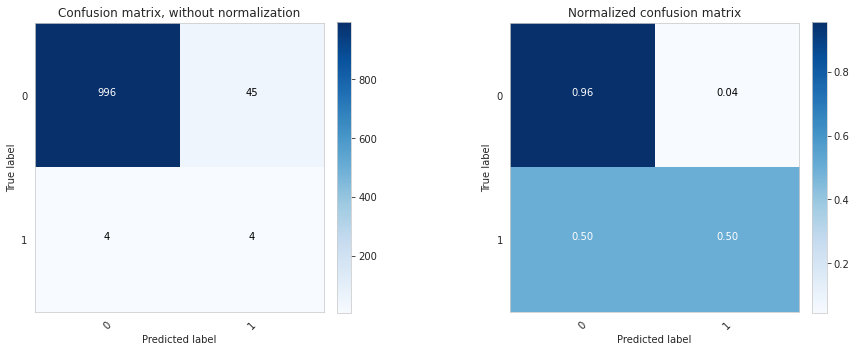

In [148]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [149]:
print(skm.classification_report(eval_targs, (eval_probs > is_example_threshold_f1).float(), [0,1], 
                                sample_weight=None))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1041
           1       0.08      0.50      0.14         8

    accuracy                           0.95      1049
   macro avg       0.54      0.73      0.56      1049
weighted avg       0.99      0.95      0.97      1049



/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

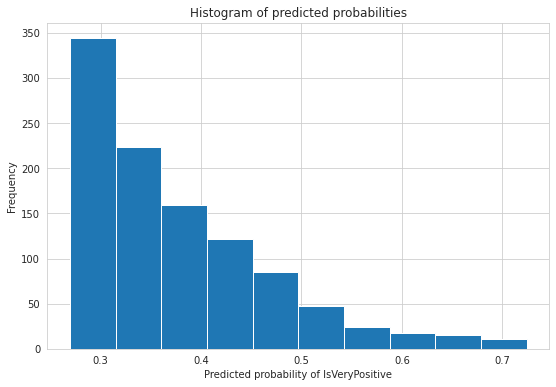

In [150]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of IsVeryPositive')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [151]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=None)

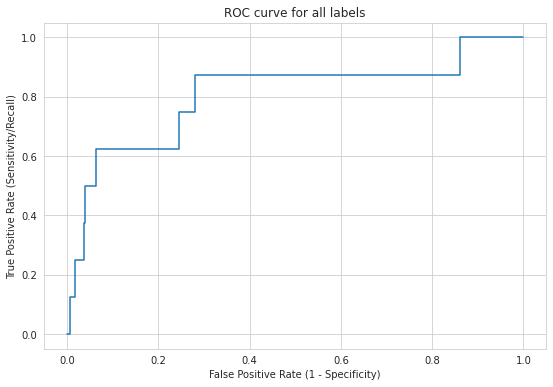

In [152]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [153]:
print(skm.roc_auc_score(eval_targs, eval_probs, average='weighted', sample_weight=None))

0.8063160422670509


### Review regression - Sentiment

In [154]:
# mse
skm.mean_squared_error(targs[0], probs[0])

0.3808008

In [155]:
# rmse
math.sqrt(skm.mean_squared_error(targs[0], probs[0]))

0.6170906039120254

In [156]:
# mae
skm.mean_absolute_error(targs[0], probs[0])

0.42812845

## Ensemble forwards and backwards passes

In [ ]:
try:
    learn_fwd.purge(); learn = None;
    learn_bwd.purge(); learn_bwd = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

bsz = 80
m_suf = '_multitask'

dls = torch.load(STANDARD_THEME_META_PATH/f'data_standard_theme_meta.pkl')

learn_fwd = load_learner(fname=STANDARD_THEME_META_PATH/f'fwd_export_mm{m_suf}.pkl')
learn_fwd.dls = dls
learn_bwd = load_learner(fname=STANDARD_THEME_META_PATH/f'bwd_export_mm{m_suf}.pkl')
learn_bwd.dls = dls

In [ ]:
learn_fwd.loss_func = multi_targ_loss
learn_bwd.loss_func = multi_targ_loss

In [ ]:
probs_fwd, lbl_fwd, loss_fwd = learn_fwd.get_preds(with_loss=True, reorder=True)
probs_bwd, lbl_bwd, loss_bwd = learn_bwd.get_preds(with_loss=True, reorder=True)

probs_fwd[0].shape, probs_bwd[0].shape, loss_fwd.shape

In [ ]:
loss_fwd.mean(), loss_bwd.mean(), (loss_fwd.mean() + loss_bwd.mean()) / 2

In [ ]:
probs_final_sent = (probs_fwd[0] + probs_bwd[0]) / 2
probs_final_is_example = (probs_fwd[1] + probs_bwd[1]) / 2

### Results

In [ ]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.9, sigmoid=False, 
                                   average='binary', sample_weight=None)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.9, sigmoid=False, 
                                   average='binary', sample_weight=None)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.9, sigmoid=False, 
                                   average='binary', sample_weight=None)

In [ ]:
is_example_prob_true_fwd = torch.softmax(probs_fwd[1], dim=-1)[:,1]
is_example_prob_true_bwd = torch.softmax(probs_bwd[1], dim=-1)[:,1]
is_example_prob_true_ensemble = torch.softmax(probs_final_is_example, dim=-1)[:,1]

# is_example_prob_true_fwd, is_example_prob_true_bwd, is_example_prob_true_ensemble

In [ ]:
# determine optimal threshold based on desired f-score
is_example_threshold_f05 = f05.opt_th(is_example_prob_true_fwd, lbl_fwd[1])
is_example_threshold_f1 = f1.opt_th(is_example_prob_true_fwd, lbl_fwd[1])
is_example_threshold_f2 = f2.opt_th(is_example_prob_true_fwd, lbl_fwd[1])

is_example_threshold_f05, is_example_threshold_f1, is_example_threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(is_example_prob_true_fwd, lbl_fwd[1], is_example_threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(is_example_prob_true_fwd, lbl_fwd[1], is_example_threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(is_example_prob_true_fwd, lbl_fwd[1], is_example_threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {is_example_threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {is_example_threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {is_example_threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {skm.accuracy_score(lbl_fwd[1], (is_example_prob_true_fwd > is_example_threshold_f1).float())}')

In [ ]:
# determine optimal threshold based on desired f-score
is_example_threshold_f05 = f05.opt_th(is_example_prob_true_bwd, lbl_fwd[1])
is_example_threshold_f1 = f1.opt_th(is_example_prob_true_bwd, lbl_fwd[1])
is_example_threshold_f2 = f2.opt_th(is_example_prob_true_bwd, lbl_fwd[1])

is_example_threshold_f05, is_example_threshold_f1, is_example_threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(is_example_prob_true_bwd, lbl_fwd[1], is_example_threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(is_example_prob_true_bwd, lbl_fwd[1], is_example_threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(is_example_prob_true_bwd, lbl_fwd[1], is_example_threshold_f2, sigmoid=False).item()

print('Backwards Only\n-------------')
print(f'f05:\tOptimal threshold = {is_example_threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {is_example_threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {is_example_threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {skm.accuracy_score(lbl_fwd[1], (is_example_prob_true_bwd > is_example_threshold_f1).float())}')

In [ ]:
# determine optimal threshold based on desired f-score
is_example_threshold_f05 = f05.opt_th(is_example_prob_true_ensemble, lbl_fwd[1])
is_example_threshold_f1 = f1.opt_th(is_example_prob_true_ensemble, lbl_fwd[1])
is_example_threshold_f2 = f2.opt_th(is_example_prob_true_ensemble, lbl_fwd[1])

is_example_threshold_f05, is_example_threshold_f1, is_example_threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(is_example_prob_true_ensemble, lbl_fwd[1], is_example_threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(is_example_prob_true_ensemble, lbl_fwd[1], is_example_threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(is_example_prob_true_ensemble, lbl_fwd[1], is_example_threshold_f2, sigmoid=False).item()

print('Ensemble Only\n-------------')
print(f'f05:\tOptimal threshold = {is_example_threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {is_example_threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {is_example_threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {skm.accuracy_score(lbl_fwd[1], (is_example_prob_true_ensemble > is_example_threshold_f1).float())}')

In [ ]:
# sentiment metrics
sentiment_mae = skm.mean_absolute_error(lbl_fwd[0], probs_final_sent)
sentiment_mse = skm.mean_squared_error(lbl_fwd[0], probs_final_sent)
sentiment_rmse = math.sqrt(skm.mean_squared_error(lbl_fwd[0], probs_final_sent))

print(sentiment_mae, sentiment_mse, sentiment_rmse)

In [ ]:
final_valid_loss = (loss_fwd.mean() + loss_bwd.mean()) / 2; final_valid_loss

In [ ]:
float(sentiment_mae)

In [ ]:
# save this information to be added to inference returned data
model_results = {
    'is_example_threshold_f05': is_example_threshold_f05,
    'is_example_threshold_f1': is_example_threshold_f1,
    'is_example_threshold_f2': is_example_threshold_f2,
    
    'val_acc_f05': val_acc_f05,
    'val_acc_f1': val_acc_f1,
    'val_acc_f2': val_acc_f2,
    
    'sentiment_mae': float(sentiment_mae),
    'sentiment_mse': float(sentiment_mse),
    'sentiment_rmse': float(sentiment_rmse),
    
    'final_valid_loss': final_valid_loss.item()
}

with open(STANDARD_THEME_META_PATH/'model_results.json', 'w') as f: json.dump(model_results, f)

### Inference (ad-hoc documents)

In [ ]:
print(STANDARD_THEME_META_LABELS)

In [ ]:
test_comments = [
    'The parking situation REALLY sucks around here.  It needs to be fixed',
    'I LOVE working at UCSD!!!  It is wonderful',
    """Some staff are just uninformed.There is no support for solo-individual study (no closed off rooms).
        Once a guy (quite tall) walked in into the girl's restroom and used the stalls standing up. 
        There was no line in the guy's restroom. This happened when I done and was going to walk out. 
        I was extremely uncomfortable""",
    "I love UCSD!!! It is a terrible place to work!",
    "I was really uncomfortable to express my opinion!!!"
]

for c in test_comments: print(learn_fwd.predict(c, with_input=True))

### Inference (batch ensemble)

In [ ]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multitask'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
verbatims_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'20200511_ensemble_predictions_multilabel.csv', 
                           dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df.copy() #verbatims_df[test_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df))

corpus_cols = ['theme', 'AnswerText'] 

In [ ]:
inf_df.head(1)

In [ ]:
pred_theme_cols = filter_col = [col for col in inf_df if col.startswith('prob_')]
# pred_theme_cols

In [ ]:
inf_df = inf_df.melt(id_vars=list(TASK_LM_DTYPES.keys()) + ['threshold_f05', 'threshold_f1', 'threshold_f2', 'val_acc_f05', 'val_acc_f1', 'val_acc_f2', 'val_loss'], 
                     value_vars=pred_theme_cols, 
                     var_name='theme', 
                     value_name='theme_prob')
len(inf_df)

In [ ]:
inf_df = inf_df.loc[inf_df.theme_prob >= inf_df.threshold_f2]
len(inf_df)

In [ ]:
inf_df['url_friendly_theme'] = inf_df.theme.apply(
    lambda s: re.sub("(.*?)_([a-zA-Z])","\g<1> \g<2>",s).replace('prob', '').strip().title().replace(' ',''))

inf_df['theme'] = inf_df.url_friendly_theme.apply(lambda s: re.sub("([a-z])([A-Z])","\g<1> \g<2>",s))

In [ ]:
inf_df.reset_index(inplace=True)

In [ ]:
inf_df.head()

In [ ]:
def get_model_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(fname=STANDARD_THEME_META_PATH/f'{model_prefix}_export_mm_{m_suf}.pkl', cpu=False)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    tok_inf_df, tok_counts = tokenize_df(inf_df, corpus_cols)
    inf_dl = inf_learn.dls.test_dl(tok_inf_df, rm_type_tfms=None, bs=128)
    if (backwards): inf_dl.tfms.add(Transform(lambda nums: nums.flip(0)))

    # 3. get probs
    test_probs_sent, test_probs_is_example = [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()
            
            # note: even though there is no targets, each batch is a tuple!
            probs, raw_outputs, outputs = inf_learn.model(b[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs_sent.append(to_detach(probs[0]))
            test_probs_is_example.append(to_detach(probs[1]))

    all_probs_sent = L(torch.cat(test_probs_sent))
    all_probs_is_example = L(torch.cat(test_probs_is_example))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs_sent = all_probs_sent[0][np.argsort(inf_dl.get_idxs())]
    all_probs_is_example = all_probs_is_example[0][np.argsort(inf_dl.get_idxs())]

    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs_sent, all_probs_is_example

In [ ]:
%time

probs_fwd_sent, probs_fwd_is_example = get_model_results(backwards=False, m_suf='multitask')
probs_bwd_sent, probs_bwd_is_example = get_model_results(backwards=True, m_suf='multitask')

probs_final_sent = (probs_fwd_sent + probs_bwd_sent) / 2
probs_final_is_example = torch.softmax((probs_fwd_is_example + probs_bwd_is_example) / 2, dim=-1)[:,1]

# probs_final = torch.sigmoid((probs_fwd + probs_bwd) / 2)

print(probs_final_sent.shape)
print(probs_final_sent[:5])
print(probs_final_is_example.shape)
print(probs_final_is_example[:5])

Add the probabilities of each label to `inf_df`

In [ ]:
np.concatenate((probs_final_sent.numpy(), probs_final_is_example.numpy()[:,None]), axis=1)

In [ ]:
combined_probs = np.concatenate((probs_final_sent.numpy(), probs_final_is_example.numpy()[:,None]), axis=1)

In [ ]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_META_LABELS]
probs_df = pd.DataFrame(combined_probs, columns=prob_labels)
probs_df.head()

In [ ]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)
final_df.head()

Add in predictions based on f1 threshold

In [ ]:
for lbl in STANDARD_THEME_META_LABELS[1:]:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > is_example_threshold_f1).astype(np.int64)

Include found thresholds

In [ ]:
final_df['is_example_threshold_f05'] = is_example_threshold_f05
final_df['is_example_threshold_f1'] = is_example_threshold_f1
final_df['is_example_threshold_f2'] = is_example_threshold_f2

final_df['is_example_val_acc_f05'] = val_acc_f05
final_df['is_example_val_acc_f1'] = val_acc_f1
final_df['is_example_val_acc_f2'] = val_acc_f2

In [ ]:
final_df['sentiment_mae'] = sentiment_mae.item()
final_df['sentiment_mse'] = sentiment_mse.item()
final_df['sentiment_rmse'] = sentiment_rmse

In [ ]:
final_df['val_loss_metadata'] = final_valid_loss.item()

In [ ]:
final_df.head()

In [ ]:
import datetime
final_df.to_csv(STANDARD_THEME_META_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

### Playground

In [ ]:
final_df.head()

In [ ]:
print(final_df[final_df.Id == 589305].AnswerText.values[0])
final_df[final_df.Id == 589305]

In [ ]:
print(final_df.iloc[0].is_example_threshold_f05)
print(final_df.iloc[0].is_example_threshold_f1)
print(final_df.iloc[0].is_example_threshold_f2)
print(final_df.prob_avg_sentiment.mean())

In [ ]:
len(learn.opt.param_groups)

In [ ]:
[ print(f'{lg}\n') for lg in learn.opt.param_groups ]

In [ ]:
losses = np.array([1,2,3,4,5,6,7,8,9,10]); losses

In [ ]:
losses.mean()

In [ ]:
(losses[:5].mean() + losses[5:].mean()) / 2